In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator  
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import GridSearchCV

In [2]:
class MajorityVoteClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [3]:
iris = datasets.load_iris()
X,y = iris.data[50:, [1,2]], iris.target[50:]

le = LabelEncoder()

y = le.fit_transform(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [5]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1, solver='lbfgs')

clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [6]:
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


# Applying the MajorityVoteClassifier

In [7]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


# Evaluating and tuning the ensemble classifier

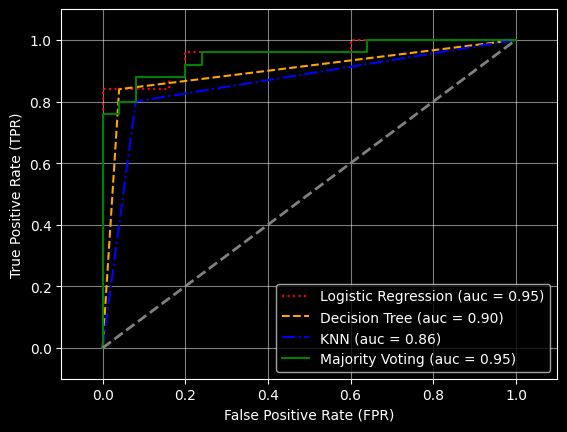

In [ ]:
# the logistic regression model performs similarly to the majority vote classifier, which is probably due to high variance (sensitivity to training data).
colors = ['red', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr, color=clr, linestyle=ls,label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### looking at the decision boundaries of each of the classifiers AND the ensemble (Majority Vote Classifier)
### - notice that the MVC decision boundary looks like a blend of the individual clasifiers

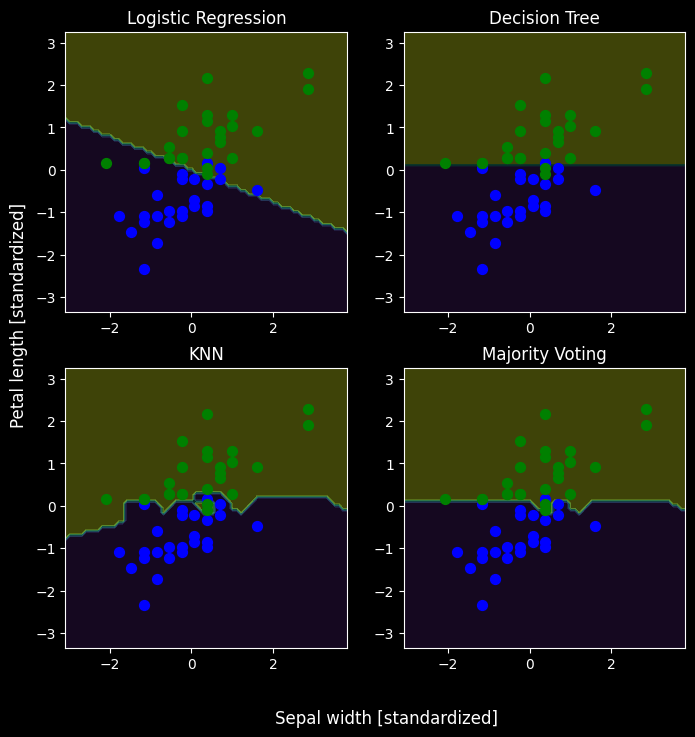

In [14]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for idx, clf,tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                      X_train_std[y_train==0, 1],
                                      c='blue', marker='o',
                                      s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                      X_train_std[y_train==1, 1],
                                      c='green', marker='o',
                                      s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5,-5., s ='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5,4.5, s ='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()
    

In [15]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

#### based on the get_params() method above, we can see the output parameters of each of the individual classifiers.  Below, we will implement a grid search to tune the regularization parameter C of the logistic regression classifier and the decision tree depth

In [17]:
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train, y_train)

,estimator,MajorityVoteC...ghbors=1)]])])
,param_grid,"{'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,pipeline-1,Pipeline(step...om_state=1)]])


In [18]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [19]:
print(f'Best parameters: {grid.best_params_}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [20]:
print(f'ROC AUC: {grid.best_score_:.2f}')

ROC AUC: 0.98
